## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [36]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-10 18:52:05--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-10 18:52:06--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-K

In [37]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [5]:
CUDA_DEVICE_ID = 0  # change if needed

In [6]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.16MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.89MB/s]


Text(0.5, 1.0, 'Image label: 5')

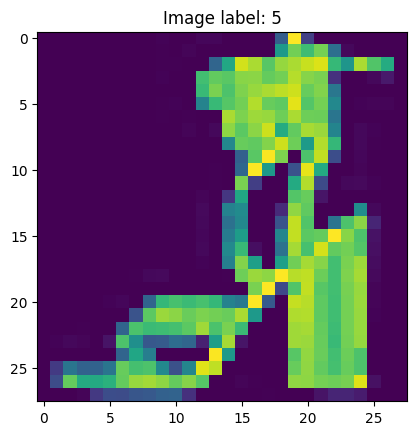

In [7]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [8]:
train_fmnist_data[0][0].size()

torch.Size([1, 28, 28])

In [40]:
# Creating model instance
model_task_1 = nn.Sequential(nn.Conv2d(1, 15, 3, padding=1, padding_mode='replicate'), # 28*28
                             nn.MaxPool2d(kernel_size=2), # 14*14
                             nn.SiLU(),

                             nn.Conv2d(15, 15, 3, padding=1), # 14*14
                             nn.MaxPool2d(kernel_size=2), # 7*7
                             nn.SiLU(),

                             nn.Conv2d(15, 15, 1, padding=0), # 7*7
                             nn.SiLU(),
                             nn.Flatten(),
                             nn.Linear(7 * 7 * 15, 10),
                             #nn.SiLU(),
                             #nn.Linear(100, 10)
                             )
# your code here

Не забудьте перенести модель на выбранный `device`!

In [41]:
model_task_1.to(device)

Sequential(
  (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): SiLU()
  (3): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): SiLU()
  (6): Conv2d(15, 15, kernel_size=(1, 1), stride=(1, 1))
  (7): SiLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=735, out_features=10, bias=True)
)

Локальные тесты для проверки вашей модели доступны ниже:

In [42]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [43]:
# your code here
crit = nn.CrossEntropyLoss()
lr = 1e-3
opt = torch.optim.Adam(model_task_1.parameters(), lr=lr)

In [44]:
# your code here
epochs = 10

In [46]:
# your code here
#opt.param_groups[0]['lr'] = 0.0001

In [47]:
# your code here
for epoch in range(epochs):
    model_task_1.train()
    mean_train_loss = 0
    mean_train_acc = 0
    for X, label in train_data_loader:

        X, label = X.to(device), label.to(device)
        opt.zero_grad()
        output = model_task_1(X)
        loss = crit(output, label)

        loss.backward()
        opt.step()
        with torch.no_grad():
            mean_train_loss += loss
            mean_train_acc += torch.sum(torch.argmax(output, dim=1) == label, dtype=torch.float32)
    with torch.no_grad():
        mean_train_loss /= float(len(train_data_loader))
        mean_train_acc /= float(len(train_fmnist_data))

    model_task_1.eval()
    mean_test_loss = 0
    mean_test_acc = 0
    with torch.no_grad():
        for X, label in test_data_loader:
            X, label = X.to(device), label.to(device)
            output = model_task_1(X)
            loss = crit(output, label)
            mean_test_loss += loss
            mean_test_acc += torch.sum(torch.argmax(output, dim=1) == label, dtype=torch.float32)
        mean_test_loss /= len(test_data_loader)
        mean_test_acc /= len(test_fmnist_data)
    print(f'Epoch {epoch + 1} from {epochs}. \n Train loss: {mean_train_loss} \n Train accuracy: {mean_train_acc} \n Test loss: {mean_test_loss} \n Test accuracy: {mean_test_acc}')


Epoch 1 from 10. 
 Train loss: 0.21990688145160675 
 Train accuracy: 0.9202666878700256 
 Test loss: 0.27797383069992065 
 Test accuracy: 0.903499960899353
Epoch 2 from 10. 
 Train loss: 0.21657386422157288 
 Train accuracy: 0.921500027179718 
 Test loss: 0.2768573760986328 
 Test accuracy: 0.902999997138977
Epoch 3 from 10. 
 Train loss: 0.21530134975910187 
 Train accuracy: 0.9216166734695435 
 Test loss: 0.2759147584438324 
 Test accuracy: 0.9031999707221985
Epoch 4 from 10. 
 Train loss: 0.21391353011131287 
 Train accuracy: 0.9223499894142151 
 Test loss: 0.27476465702056885 
 Test accuracy: 0.903499960899353
Epoch 5 from 10. 
 Train loss: 0.2132146954536438 
 Train accuracy: 0.9233500361442566 
 Test loss: 0.2746141850948334 
 Test accuracy: 0.9034000039100647
Epoch 6 from 10. 
 Train loss: 0.21211376786231995 
 Train accuracy: 0.9230999946594238 
 Test loss: 0.275902658700943 
 Test accuracy: 0.9034000039100647
Epoch 7 from 10. 
 Train loss: 0.21144287288188934 
 Train accuracy:

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [48]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.92558


In [49]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9024


Проверка, что необходимые пороги пройдены:

In [50]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [51]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

File saved to `submission_dict_fmnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_fmnist_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!